In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('D:/Wisdom/workspace_python/research')
sys.path=list(set(sys.path))

import keras
from keras import backend as K
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout)
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

from model import keras_models
from model.keras_models import create_dense_layers, inst_layers
from module_DTI.utils import plot_mse_mae_history, plot_roc_curve, plot_epoch_acc_loss

In [2]:
mnist=input_data.read_data_sets("../dataset/MNIST_data/",one_hot=False)
print(mnist.train.num_examples)
print(mnist.validation.num_examples)
print(mnist.test.num_examples)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../dataset/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../dataset/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../dataset/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
55000
5000
10000


In [3]:
pixel=28
image_size=pixel*pixel
n_class=10

In [65]:
x_train,y_train=mnist.train.next_batch(55000)
x_val,y_val=mnist.validation.next_batch(5000)
x_test,y_test=mnist.test.next_batch(10000)
tmp_y_test=y_test
tmp_y_train=y_train
y_train,y_val,y_test=to_categorical(y_train),to_categorical(y_val),to_categorical(y_test)
# x=(x-np.min(x,axis=0))/(np.max(x,axis=0)-np.min(x,axis=0))
# y=target
# y=to_categorical(target)
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=1)
x_train.shape

AttributeError: module 'keras.datasets.mnist' has no attribute 'train'

In [79]:
batch_size=100
original_dim=image_size
intermediate_dim=512
latent_dim=2

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(0.5*z_log_sigma) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
vae = Model(x, x_decoded_mean)
encoder = Model(x, z_mean)
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)
def vae_loss(x, x_decoded_mean):
    xent_loss = keras.losses.mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(loss=vae_loss,optimizer=Adam())

In [80]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=30,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 24s 400us/step - loss: 0.0782 - val_loss: 0.0681
Epoch 2/30
60000/60000 [==============================] - 18s 300us/step - loss: 0.0676 - val_loss: 0.0677
Epoch 3/30
60000/60000 [==============================] - 16s 268us/step - loss: 0.0674 - val_loss: 0.0676
Epoch 4/30
60000/60000 [==============================] - 18s 292us/step - loss: 0.0674 - val_loss: 0.0676
Epoch 5/30
60000/60000 [==============================] - 17s 282us/step - loss: 0.0674 - val_loss: 0.0676
Epoch 6/30
60000/60000 [==============================] - 17s 278us/step - loss: 0.0674 - val_loss: 0.0676
Epoch 7/30
60000/60000 [==============================] - 17s 292us/step - loss: 0.0673 - val_loss: 0.0676
Epoch 8/30
60000/60000 [==============================] - 19s 317us/step - loss: 0.0673 - val_loss: 0.0675
Epoch 9/30
60000/60000 [==============================] - 21s 342us/step - loss: 0.0673 - val_

In [81]:
x_test_encoded = encoder.predict(x_train)
# plt.figure(figsize=(6, 6))


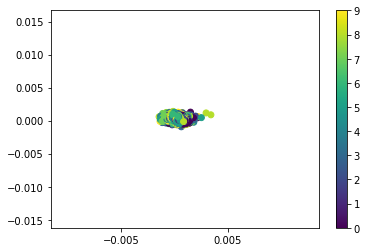

In [82]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_train)
plt.xticks([-0.005,0.005])
plt.colorbar()
plt.show()

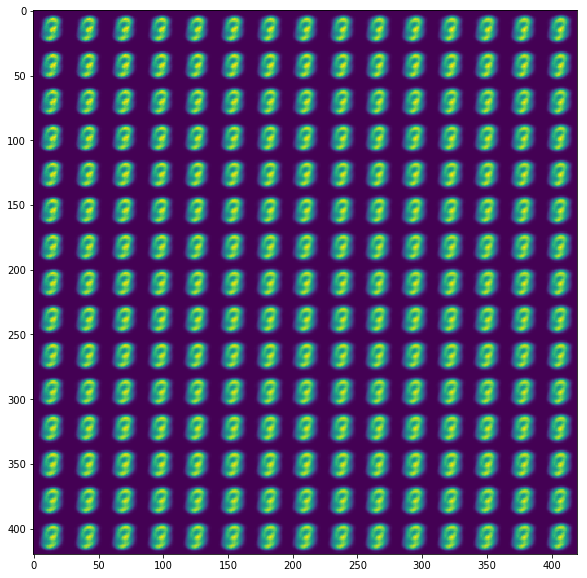

In [83]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

(10000, 30)

In [47]:
#h_VAE=vae.fit(x_train,x_train,batch_size=batch_size,epochs=50,validation_data=(x_val,x_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 15s 280us/step - loss: 0.3164 - mean_squared_error: 0.0738 - mean_absolute_error: 0.1694 - val_loss: 0.2633 - val_mean_squared_error: 0.0673 - val_mean_absolute_error: 0.1504
Epoch 2/30
55000/55000 [==============================] - 14s 249us/step - loss: 0.2631 - mean_squared_error: 0.0674 - mean_absolute_error: 0.1502 - val_loss: 0.2632 - val_mean_squared_error: 0.0673 - val_mean_absolute_error: 0.1485
Epoch 3/30
55000/55000 [==============================] - 15s 281us/step - loss: 0.2631 - mean_squared_error: 0.0673 - mean_absolute_error: 0.1502 - val_loss: 0.2630 - val_mean_squared_error: 0.0672 - val_mean_absolute_error: 0.1502
Epoch 4/30
55000/55000 [==============================] - 14s 247us/step - loss: 0.2631 - mean_squared_error: 0.0673 - mean_absolute_error: 0.1502 - val_loss: 0.2632 - val_mean_squared_error: 0.0673 - val_mean_absolute_error: 0.1483
